In [40]:
%load_ext autoreload
%autoreload 2
import os, random
import numpy as np
import torch
import dataset_loader

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

def build_torch_inputs(data):
    x, y = data
    ret = list()
    
    for i in range(x.shape[0]):
        input_tensor = torch.from_numpy(x[i]).reshape(1, -1)
        output_value = int(y[i])
        
        ret.append({
            "input_tensor": input_tensor,
            "output_value": output_value
        })
        
    return ret
        
train_data = build_torch_inputs(train_data)
dev_data = build_torch_inputs(dev_data)
test_data = build_torch_inputs(test_data)

In [5]:
# just a helper function
def build_batch(data):
    batch_inputs = torch.cat(
        [data["input_tensor"] for data in data],
        dim=0
    )

    labels = torch.LongTensor([data["output_value"] for data in data ])
    
    return batch_inputs, labels

In [6]:
# A network network is a class extending nn.Module
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_proj = nn.Linear(input_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, output_dim)
                
        with torch.no_grad():
            torch.nn.init.kaiming_uniform_(hidden_proj.weight.data)
            torch.nn.init.kaiming_uniform_(output_proj.weight.data)
            
            self.hidden_proj.bias.zero_()
            self.output_proj.bias.zero_()
        
    def forward(self, inputs):
        z = self.hidden_proj(inputs)
        z = torch.relu(z)
        return self.output_proj(z)

In [ ]:
logits = torch.tensor([
    [432699.1875, 300807.1250, 389614.0312, 396122.1562, 410441.5625, 280411.0000, 426984.9375, 382853.3750, 427784.6875, 344430.3125],
    [174335.7188, 121234.3125, 156996.5781, 159618.2188, 165396.4844, 112990.3438, 172047.2812, 154292.2500, 172379.9531, 138800.5625],
    [284093.5625, 197565.0625, 255842.6250, 260127.5938, 269514.0312, 184131.4375, 280361.3125, 251412.3125, 280909.1250, 226173.8438],
    [219632.6406, 152675.4844, 197763.0312, 201069.3125, 208362.4062, 142334.1094, 216726.0625, 194384.1094, 217143.9688, 174859.1250],
    ])

labels = torch.tensor([8, 7, 3, 7], dtype=int)

perfect_logits = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 427784.6875, 0],
    [0, 0, 0, 0, 0, 0, 0, 154292.2500, 0, 0],
    [0, 0, 0, 260127.5938, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 194384.1094, 0, 0]
    ])

def nll_loss_custom(logits, labels):
    # Calculate the range of indices for the batch elements  
    batch_indices = range(logits.shape[0])
    # Select the logit for the correct label of each batch element  
    selected_logits = logits[batch_indices, labels]
    # Use the logsumexp function to calculate the log of the sum of exponentials of the logits  
    log_sum_exp = torch.logsumexp(logits, dim=1)
    # Calculate the mean negative log likelihood loss for the batch  
    loss = - selected_logits + log_sum_exp
    return loss.mean()


print(f"F.nll_loss : {F.nll_loss(F.log_softmax(logits, dim=1), labels,reduction='mean')}")
# print(f'nll_loss_custom : {nll_loss_custom(F.log_softmax(logits, dim=1), labels)}')
print(f'nll_loss_custom : {nll_loss_custom(logits, labels)}')
print(f'nll_loss_custom perfect pred : {nll_loss_custom(perfect_logits, labels)}')

# assert F.nll_loss(logits, labels) == nll_loss_custom(logits, labels)



F.nll_loss : 18543.1171875
tensor([427784.6875, 154292.2500, 260127.5938, 194384.1094])
nll_loss_custom : 18543.1171875
tensor([427784.6875, 154292.2500, 260127.5938, 194384.1094])
nll_loss_custom perfect pred : 0.0


In [ ]:
# Example of a training loop! :)

# hyper-parameters
n_epochs = 10
batch_size = 5

# Build the network
network = MLPClassifier(784, 200, 10)
if torch.cuda.is_available(): network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1e-3, momentum=0.9)

for epoch in range(n_epochs):
    print("%i / %i" % (epoch+1, n_epochs))
    
    random.shuffle(train_data)
    
    network.train()
    
    for first_element in range(0, len(train_data), batch_size):
        optimizer.zero_grad()
        
        batch_input, labels = build_batch(train_data[first_element:first_element + batch_size])
        if torch.cuda.is_available(): labels = labels.to(device)
        if torch.cuda.is_available(): logits = network(batch_input)          
        logits = network(batch_input)
        # Modified loss to take into account partial labeling
        loss = nll_loss_custom(logits, labels)
        
        loss.backward()

        optimizer.step()
        
    n_correct = 0
    with torch.no_grad(): 
        network.eval()
        
        for first_element in range(0, len(dev_data), batch_size):
            optimizer.zero_grad()

            batch_input, labels = build_batch(dev_data[first_element:first_element + batch_size])
            if torch.cuda.is_available(): labels = labels.to(device)
            if torch.cuda.is_available(): logits = network(batch_input)  
            logits = network(batch_input)
            
            prediction = logits.argmax(dim=1)
            
            n_correct += (prediction == labels).sum().item()

    print("Dev acc: %.2f" % (100 * n_correct / len(dev_data)))

1 / 10
Dev acc: 94.16
2 / 10
Dev acc: 95.72
3 / 10
Dev acc: 96.25
4 / 10
Dev acc: 96.63
5 / 10
Dev acc: 97.10
6 / 10
Dev acc: 97.16
7 / 10
Dev acc: 97.16
8 / 10
Dev acc: 97.45
9 / 10
Dev acc: 97.41
10 / 10
Dev acc: 97.61


# Partial labeling

In [7]:
print('Before adding noise : ', [data['output_value'] for data in train_data][:50])

# Add noise in data, meaning instead of one label for 'output_value', we will have 3 labels in 30% of the cases
def add_noise(data):
    for i in range(len(data)):
        if(random.random() < 0.3):
            range_sample = list(range(10))
            range_sample.remove(data[i]["output_value"])
            new_samples = random.sample(range_sample, 2)
            new_label = [data[i]["output_value"], new_samples[0], new_samples[1]]
            random.shuffle(new_label)
            data[i]["output_value"] = new_label
        else:
            label = data[i]['output_value']
            data[i]['output_value'] = [label]
    return data

train_data = add_noise(train_data)

print('After adding noise : ', [data['output_value'] for data in train_data][:50])


Before adding noise :  [1, 7, 4, 6, 4, 1, 8, 5, 9, 3, 9, 4, 4, 4, 5, 0, 7, 8, 9, 6, 5, 4, 5, 1, 9, 5, 4, 7, 6, 6, 0, 0, 4, 8, 4, 9, 4, 8, 1, 7, 5, 2, 5, 5, 6, 4, 6, 9, 5, 5]
After adding noise :  [[1], [7], [4], [8, 0, 6], [9, 4, 1], [1], [8], [5], [9], [0, 3, 7], [4, 3, 9], [4], [4], [4], [5], [1, 0, 3], [7], [8], [9], [6], [5], [4], [7, 5, 4], [1, 7, 3], [9], [5], [4], [7], [6], [3, 6, 9], [0], [0], [4, 8, 0], [8], [4], [9], [4], [8], [1], [7], [5], [2], [5], [5, 0, 4], [6], [4], [6], [9, 1, 8], [5], [5]]


In [ ]:
logits = torch.tensor([
    [432699.1875, 300807.1250, 389614.0312, 396122.1562, 410441.5625, 280411.0000, 426984.9375, 382853.3750, 427784.6875, 344430.3125],
    [174335.7188, 121234.3125, 156996.5781, 159618.2188, 165396.4844, 112990.3438, 172047.2812, 154292.2500, 172379.9531, 138800.5625],
    [284093.5625, 197565.0625, 255842.6250, 260127.5938, 269514.0312, 184131.4375, 280361.3125, 251412.3125, 280909.1250, 226173.8438],
    [219632.6406, 152675.4844, 197763.0312, 201069.3125, 208362.4062, 142334.1094, 216726.0625, 194384.1094, 217143.9688, 174859.1250],
    ])



perfect_logits = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 427784.6875, 0],
    [0, 0, 156996.5781, 0, 0, 0, 0, 154292.2500, 0, 0],
    [284093.5625, 0, 0, 260127.5938, 0, 0, 0, 251412.3125, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 194384.1094, 0, 0]
    ])

# Define the number of classes  
num_classes = logits.shape[1]  

# Create a tensor of labels  
labels = [[8], [7, 2], [3, 8, 0], [7]]
# print(f'labels : {labels}')
tensor_labels = list()
for ls in labels:
    t = torch.zeros(num_classes, dtype=torch.long)
    t[ls] = 1
    tensor_labels.append(t)
tensor_labels = torch.stack(tensor_labels)
print(f'labels one hot : {tensor_labels}')

def nll_loss_marginalized(logits, labels):
    mask = torch.zeros_like(logits)
    mask[labels==0]=float("-inf")
    # Select the logit for the correct label/set of labels of each batch element
    selected_logits = logits + mask
    log_sum_exp_selected_logits = torch.logsumexp(selected_logits, dim=1)
    # Use the logsumexp function to calculate the log of the sum of exponentials of the logits  
    log_sum_exp = torch.logsumexp(logits, dim=1)
    # Calculate the mean negative log likelihood loss for the batch  
    loss = - log_sum_exp_selected_logits + log_sum_exp
    return loss.mean()

print(f'nll_loss_marginalized : {nll_loss_marginalized(logits, tensor_labels)}')
print(f'nll_loss_marginalized perfect prediction : {nll_loss_marginalized(perfect_logits, tensor_labels)}')


labels one hot : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
nll_loss_marginalized : 11875.54296875
nll_loss_marginalized perfect prediction : 0.0


In [ ]:
def build_batch_noised(data, num_classes):
    batch_inputs = torch.cat(
        [data["input_tensor"] for data in data],
        dim=0
    )

    labels = [data["output_value"] for data in data]

    labels = [F.one_hot(torch.tensor(l), num_classes =num_classes) if isinstance(l,int) else sum(F.one_hot(torch.tensor(l), num_classes =num_classes)) for l in labels]
    labels = torch.stack(labels)
    
    return batch_inputs, labels
print('After adding noise : ', [data['output_value'] for data in train_data][:5])
print(build_batch_noised(train_data[:5], 10)[1])

After adding noise :  [[5], [4], [4], [3], [5]]
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


1 / 10
Dev acc: 89.16
2 / 10
Dev acc: 90.78
3 / 10
Dev acc: 91.71
4 / 10
Dev acc: 92.24
5 / 10
Dev acc: 92.74
6 / 10
Dev acc: 93.06
7 / 10
Dev acc: 93.41
8 / 10
Dev acc: 93.74
9 / 10
Dev acc: 94.22
10 / 10
Dev acc: 94.36


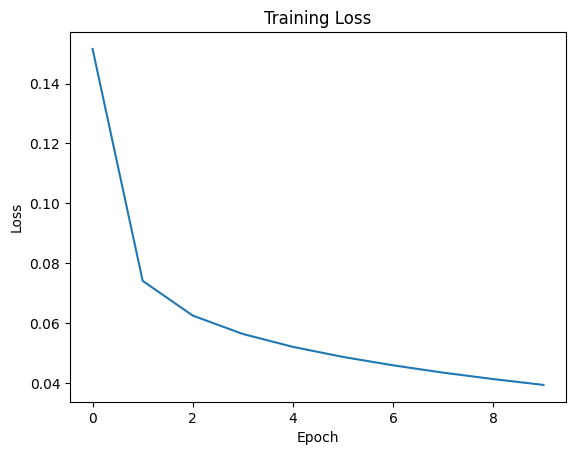

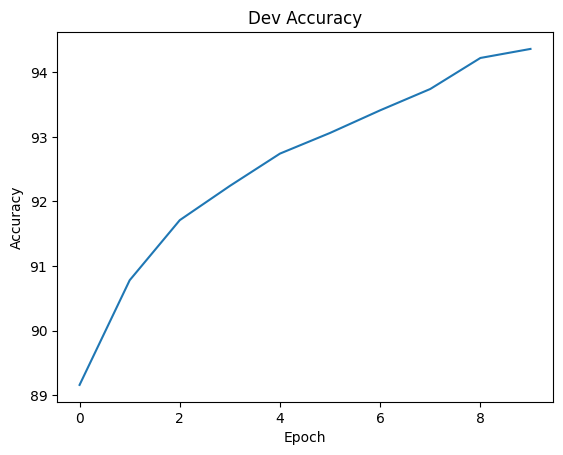

In [ ]:
import matplotlib.pyplot as plt  
  
def count_correct_preds(predictions_one_hot, labels):  
    num_correct = 0    
    for i in range(predictions_one_hot.size(0)):    
        pred = torch.argmax(predictions_one_hot[i])    
        label = torch.nonzero(labels[i]).flatten()    
        if pred in label:    
            num_correct += 1    
    return num_correct    
  
# hyper-parameters  
batch_size = 5
  
# Build the network  
network = MLPClassifier(784, 200, 10)  
if torch.cuda.is_available(): network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1e-3, momentum=0.1)  
  
train_losses = []  
dev_accs = []  
  
for epoch in range(n_epochs):  
    print("%i / %i" % (epoch+1, n_epochs))  
      
    random.shuffle(train_data)  
      
    network.train()  
    train_loss = 0
      
    for first_element in range(0, len(train_data), batch_size):  
        optimizer.zero_grad()  
          
        batch_input, labels = build_batch_noised(train_data[first_element:first_element + batch_size], 10)  
        if torch.cuda.is_available(): batch_input = batch_input.to(device)
        if torch.cuda.is_available(): labels = labels.to(device)
        logits = network(batch_input)  
        # Modified loss to take into account partial labeling  
        loss = nll_loss_marginalized(logits, labels)  
        loss.backward()  
  
        optimizer.step()  
          
        train_loss += loss.item()  
          
    train_losses.append(train_loss / len(train_data))  
    n_correct = 0  
    with torch.no_grad():   
        network.eval()  
          
        for first_element in range(0, len(dev_data), batch_size):  
            batch_input, labels = build_batch_noised(dev_data[first_element:first_element + batch_size], 10)  
            if torch.cuda.is_available(): batch_input = batch_input.to(device)
            if torch.cuda.is_available(): labels = labels.to(device)
            logits = network(batch_input)  
              
            prediction = logits.argmax(dim=1)  
              
            n_correct += count_correct_preds(F.one_hot(prediction, num_classes=10), labels)  
  
    dev_acc = 100 * n_correct / len(dev_data)  
    dev_accs.append(dev_acc)  
    print("Dev acc: %.2f" % dev_acc)
      
# Plot the training loss and dev accuracy  
plt.plot(train_losses)  
plt.title('Training Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.show()  
  
plt.plot(dev_accs)  
plt.title('Dev Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.show()  


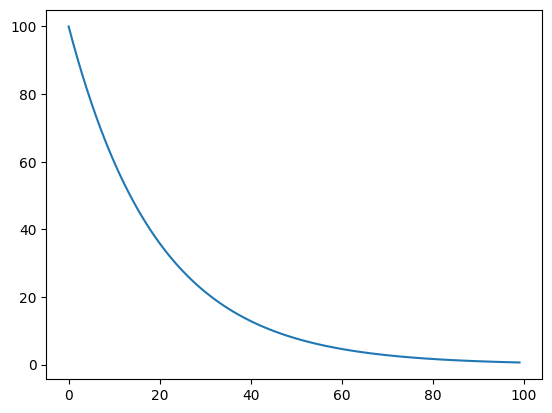

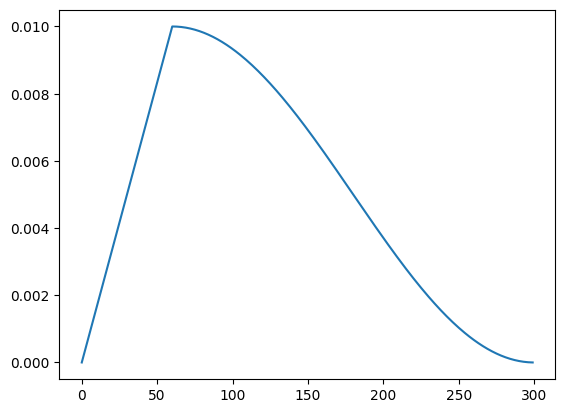

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import transformers

n_epochs = 100

model = nn.Linear(10, 5)
optimizer = optim.SGD(model.parameters(), lr=100)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda1)

lrs = []
for i in range(n_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)
plt.show()

# ---------------------------------------------------------------------------
total_samples = 968
bs = 32
n_epochs = 10

num_warmup_steps = (total_samples // bs) * 2
num_total_steps = (total_samples // bs) * n_epochs

model = nn.Linear(2, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, 
                                                         num_warmup_steps=num_warmup_steps, 
                                                         num_training_steps=num_total_steps)
lrs = []
for i in range(num_total_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)
plt.show()

# Partial Labeling with ratio constraints

In [ ]:
preds = torch.tensor([[0.91256185, 0.17851141, 0.22250389, 0.33196032, 0.39393268,0.06549098, 0.67783285, 0.45183095, 0.45786714, 0.40165077],
       [0.70385266, 0.23925936, 0.7695696 , 0.42046439, 0.81585899,0.54890951, 0.7006783 , 0.23177555, 0.02604559, 0.47375653],
       [0.35760887, 0.82051204, 0.568982  , 0.08858827, 0.84830185,0.15142244, 0.05623801, 0.52032449, 0.19970964, 0.52910059],
       [0.05463184, 0.1481239 , 0.44760348, 0.58651152, 0.77316006,0.64567662, 0.35027898, 0.19289026, 0.80032864, 0.37215158]
       ]
       )

perfect_preds = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 1/2, 0, 0, 0, 0, 1/2, 0, 0],
    [1/3, 0, 0, 1/3, 0, 0, 0, 1/3, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    ])

# Define the number of classes  
num_classes = preds.shape[1]  

# Create a tensor of labels  
labels = [[8], [7, 2], [3, 8, 0], [7]]
# print(f'labels : {labels}')
tensor_labels = list()
for ls in labels:
    t = torch.zeros(num_classes, dtype=torch.long)
    t[ls] = 1
    tensor_labels.append(t)
tensor_labels = torch.stack(tensor_labels)
print(f'labels one hot : {tensor_labels}')

labels one hot : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


In [ ]:
preds = F.softmax(logits.clone().detach(), dim=1)
print(preds)
tensor_labels = labels.clone().detach()
print(labels)

tensor([[0.0664, 0.1916, 0.0784,  ..., 0.0979, 0.0763, 0.1074],
        [0.0896, 0.2030, 0.0567,  ..., 0.1250, 0.0866, 0.0880],
        [0.0774, 0.1535, 0.0298,  ..., 0.1495, 0.0585, 0.0827],
        ...,
        [0.0971, 0.1700, 0.0733,  ..., 0.1192, 0.0907, 0.0815],
        [0.1067, 0.0808, 0.0226,  ..., 0.1399, 0.1140, 0.0926],
        [0.0745, 0.0973, 0.0411,  ..., 0.1572, 0.0742, 0.1452]])
tensor([[1, 1, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 0]])


In [ ]:
b=torch.tensor([0.1 for i in range(10)])
def solve_via_bregman(W, mask, ratio, max_iter=10, eps=1):
    """
    1. Select elements of matrix to modify
    2. Apply first projection on these elements (condition 1, \sum mu_i =1)
    3. Apply second projection on these elements (condition 2, \sum mu_i on  =1)
    """
    not_mask = mask!=1
    W = - W.clone() / eps
    W[not_mask]=float("-inf")
    for _ in range(max_iter):
        # Project on first constraint set (sum of columns = 1)
        W = torch.log_softmax(W, dim=1)
        # Project on second constraint set (sum of lines = b on constrained elements)
        W = torch.log_softmax(W, dim=0) + np.log(ratio)
    return W.exp()

log_sum_exp_Z = solve_via_bregman(preds, tensor_labels, b*len(train_data))

print((log_sum_exp_Z))
print("Sum on col for constrained classes (log_sum_exp_Z.sum(dim=1)) :\n", log_sum_exp_Z.sum(dim=1))
print("Sum on rows (log_sum_exp_Z.sum(dim=0)) :\n", log_sum_exp_Z.sum(dim=0))

tensor([[0.3971, 0.2327, 0.0000,  ..., 0.0000, 0.0000, 0.3686],
        [0.0000, 0.2389, 0.0000,  ..., 0.0000, 0.4096, 0.0000],
        [1.0018, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0010],
        [0.0000, 0.2540, 0.0000,  ..., 0.0000, 0.0000, 0.3656],
        [0.0000, 0.0000, 0.3023,  ..., 0.0000, 0.0000, 0.0000]])
Sum on col for constrained classes (log_sum_exp_Z.sum(dim=1)) :
 tensor([0.9985, 0.9973, 1.0018,  ..., 1.0010, 0.9984, 1.0033])
Sum on rows (log_sum_exp_Z.sum(dim=0)) :
 tensor([5000.0083, 4999.9990, 4999.9917, 5000.0029, 4999.9941, 5000.0117,
        4999.9980, 5000.0000, 4999.9995, 4999.9966])


In [ ]:
w = torch.tensor([3., 2., -1., float('-inf')])
w.log_softmax(dim=0).exp()

def compute_logsumexp_z(W, mask, ratio):
    ratio = ratio * W.shape[0]
    with torch.no_grad():
        P = solve_via_bregman(W, mask, ratio)
    return (P*W).sum(dim=1) - torch.nan_to_num(P*P.log()).sum(dim=1)

In [ ]:
def nll_loss_eer(preds, labels, ratio):
    # Perform Bregman Projections to inlcude Expected Entity Ratio on Z
    log_sum_exp_Z = compute_logsumexp_z(preds, labels, ratio)
    
    # Calculate logsumexp on Y
    log_sum_exp_Y = torch.logsumexp(preds, dim=1)
    
    loss = - log_sum_exp_Z.mean() + log_sum_exp_Y.mean()
    return loss

ratio=0.5

print(f'nll_loss_eer : {nll_loss_eer(preds, tensor_labels, ratio)}')

nll_loss_eer : nan


1 / 10
Dev acc: 17.98
2 / 10
Dev acc: 30.18
3 / 10
Dev acc: 38.85
4 / 10
Dev acc: 45.33
5 / 10
Dev acc: 53.28
6 / 10
Dev acc: 62.54
7 / 10
Dev acc: 67.84
8 / 10
Dev acc: 69.73
9 / 10
Dev acc: 71.35
10 / 10
Dev acc: 71.88


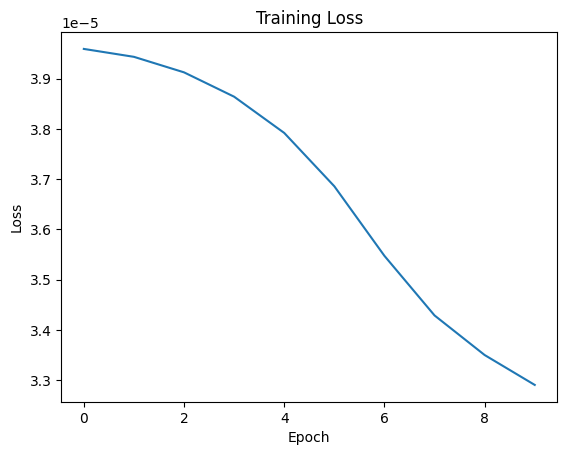

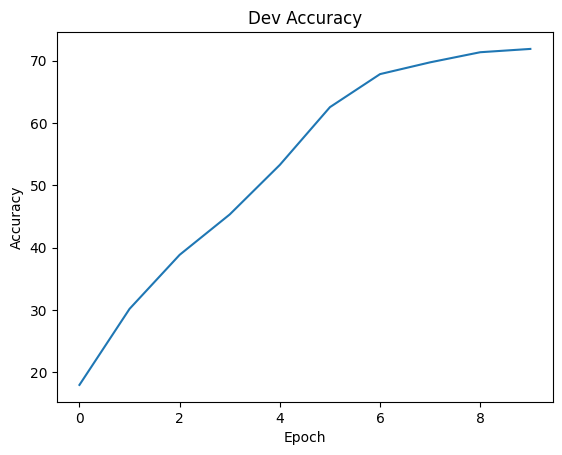

In [ ]:
import matplotlib.pyplot as plt  
  
def count_correct_preds(predictions_one_hot, labels):  
    num_correct = 0    
    for i in range(predictions_one_hot.size(0)):    
        pred = torch.argmax(predictions_one_hot[i])    
        label = torch.nonzero(labels[i]).flatten()    
        if pred in label:    
            num_correct += 1    
    return num_correct    
  
# hyper-parameters  
batch_size = int(len(train_data))
n_epochs = 10
ratio = torch.tensor([0.1 for _ in range(10)])

# Build the network  
network = MLPClassifier(784, 200, 10)  
if torch.cuda.is_available(): network.to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=1, momentum=0.9)  
  
train_losses = []  
dev_accs = []  
  
for epoch in range(n_epochs):  
    print("%i / %i" % (epoch+1, n_epochs))  
      
    random.shuffle(train_data)  
      
    network.train()  
    train_loss = 0
      
    for first_element in range(0, len(train_data), batch_size):  
        optimizer.zero_grad()  
          
        batch_input, labels = build_batch_noised(train_data[first_element:first_element + batch_size], 10)
        if torch.cuda.is_available(): batch_input = batch_input.to(device)
        if torch.cuda.is_available(): labels = labels.to(device)
        logits = network(batch_input)
        
        # Modified loss to take into account partial labeling
        loss = nll_loss_eer(F.softmax(logits, dim=1), labels, ratio)  

        loss.backward(retain_graph=True)  

        optimizer.step()  
        
        train_loss += loss.item()  
          
    train_losses.append(train_loss /len(train_data))  

    n_correct = 0  
    with torch.no_grad():   
        network.eval()

        for first_element in range(0, len(dev_data), batch_size):  
            batch_input, labels = build_batch_noised(dev_data[first_element:first_element + batch_size], 10)  
            if torch.cuda.is_available(): batch_input = batch_input.to(device)
            if torch.cuda.is_available(): labels = labels.to(device)
            logits = network(batch_input)  
              
            prediction = logits.argmax(dim=1)  
              
            n_correct += count_correct_preds(F.one_hot(prediction, num_classes=10), labels)  
  
    dev_acc = 100 * n_correct / len(dev_data)  
    dev_accs.append(dev_acc)  
    print("Dev acc: %.2f" % dev_acc)
      
# Plot the training loss and dev accuracy  
plt.plot(train_losses)  
plt.title('Training Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.show()  
  
plt.plot(dev_accs)  
plt.title('Dev Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.show() 

In [9]:
X = [data['input_tensor'] for data in train_data]
Y = []
for data in train_data:
    if type(data['output_value'])==list:
        Y.append(data['output_value'])
    else:
        Y.append([data['output_value']])

label_list=np.unique([item for l in Y  for item in l])

# Create a data loader that gives batches that make the Bregman Problem feasible.
# For this, we need in each batch to have ratio*len(batch) of each data class
# (ratio is a tensor of size (num_classes) so we have a number of data points to have
# for each class in the batch)
# The problem is that we have partial labels (sometimes y=[1] sometimes y=[1,7]) so we
# cannot use a classic WeightedRandomSampler
# We will create a custom sampler that will sample the data points in the batch
# such that we have the right number of data points for each class in the batch.

# class CustomSampler(torch.utils.data.Sampler):
#     def __init__(self, data_source, ratio):
#         self.data_source = data_source
#         self.ratio = ratio
#         self.label_list = np.unique([item for l in Y  for item in l])
#         self.label_indices = {label:[] for label in self.label_list}
#         for i, y in enumerate(Y):
#             for label in y:
#                 self.label_indices[label].append(i)
#         self.length = len(data_source)
#         self.num_classes = len(self.label_list)
        
#     def __iter__(self):
#         indices = []
#         for label in self.label_list:
#             indices += random.sample(self.label_indices[label], int(self.ratio[label.item()]*self.length))
#         random.shuffle(indices)
#         return iter(indices)
    
#     def __len__(self):
#         return self.length

# sampler = CustomSampler(Y, ratio = torch.tensor([0.1 for _ in label_list]))
# sampler_iter = iter(sampler)

# # Test with a dataloader

# dataloader = torch.utils.data.DataLoader(Y, batch_size=10000, sampler=sampler, collate_fn=lambda x: x)
# for batch in dataloader:
#     print(len(batch))
#     break

# # Check that the distribution of classes is respected in the generated batch
# batch_label_indices={label:[] for label in sampler.label_list}

# for i, y in enumerate(batch):
#     for label in y:
#         batch_label_indices[label].append(i)

# print({label:len(indices) for label, indices in batch_label_indices.items()})

# Problem with this implementation : as we add data samples with random.sample(self.label_indices[label], int(self.ratio[label.item()]*self.length)),
# we do not respect the ratio of each class in the batch. Indeed, when adding a



In [45]:
list_batch = []
for i in tqdm(range(10), desc='Creating batches'):
    batch_size = 10000
    ratio = [0.10 * batch_size for _ in range(10)]


    indices_by_class = {label:[] for label in label_list}
    for i, y in enumerate(Y):
        for label in y:
            indices_by_class[label].append(i)

    batch = []
    batch_elem_by_class = [0 for i in range(10)]
    indices=list(range(len(train_data)))

    loop_ratio = ratio.copy()

    ratio_is_satisfied = False
    while not len(batch)==batch_size:
        # print('loop_ratio : ', loop_ratio)
        # Define probability of picking elements
        prob = loop_ratio/np.sum(loop_ratio)
        prob = prob.tolist()
        prob[-1] = 1 - np.sum(prob[0:-1])

        flag=False
        # Pick a random element (with higher proba for missing elements)
        selected_y_idx = random.choice(indices)
        selected_y = Y[selected_y_idx]
        # print('len(batch) : ', len(batch), end='\r')
        # print('selected_y_idx : ', selected_y_idx, end = '\r')
        # Check that there is no label that does not meet the constraints:
        for label in selected_y:
            if batch_elem_by_class[label]==ratio[label]:
                flag = True
                continue
        if flag:
            continue
        # Add element to batch 
        # & update batch_elem_by_class
        # & Remove 1 from ratio vector to increase prob of picking an element
        # that has not been picked yet   batch.append(selected_y_idx)
        batch.append(selected_y_idx)
        for label in selected_y:
            batch_elem_by_class[label]+=1
            loop_ratio[label] -= 1

        # Remove added element from remaining y
        indices.remove(selected_y_idx)

        # Check if we respect the ratio requirements on the batch now:
        if all([elem==ratio[i] for i, elem in enumerate(batch_elem_by_class)]):
            ratio_is_satisfied = True
    list_batch.append(batch)

Creating batches:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\u011513\AppData\Local\Temp\ipykernel_11424\775593035.py:22: RuntimeWarning: invalid value encountered in divide
  prob = loop_ratio/np.sum(loop_ratio)
Creating batches:   0%|          | 0/10 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [44]:
for batch in list_batch:
    print(len(batch))

# Check that the distribution of classes is respected in the generated batch
batch_label_indices={label:[] for label in label_list}

for i, y in enumerate(batch):
    for label in Y[y]:
        batch_label_indices[label].append(i)

print({label:len(indices) for label, indices in batch_label_indices.items()})

6408
6326
6336
6422
6340
6362
6392
6394
6396
6468
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [34]:
ratio[label]

1000.0

In [165]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

class CustomSampler:
    def __init__(self, labels, ratio, batch_size):
        self.ratio = ratio
        self.label_list = np.unique([item for l in labels  for item in l])
        self.indices_by_class = {label:[] for label in self.label_list}
        for i, y in enumerate(labels):
            for label in y:
                self.indices_by_class[label].append(i)
        self.batch_size = batch_size

    def make_batch(self):
        batch = []
        loop_ratio = self.ratio.clone()
        norm_ratio = loop_ratio/loop_ratio.sum()
        # Modify the while test. It should not be on len(batch) but on the ratio of each class in the batch
        while len(batch) < self.batch_size:
            # Select a class
            class_ = np.random.choice(range(10), p=norm_ratio)
            # If there are still samples available for the selected class
            if len(self.indices_by_class[class_]) > 0:
                # Pop an index from the list of indices for this class and add it to the batch
                batch.append(self.indices_by_class[class_].pop())
                # Update the ratio tensor by subtracting 1 from the count of the selected class
                loop_ratio[class_] -= 1
        return batch
    
    def __iter__(self):
        batch = []
        loop_ratio = self.ratio.clone()
        norm_ratio = loop_ratio/loop_ratio.sum()
        # Modify the while test. It should not be on len(batch) but on the ratio of each class in the batch
        while len(batch) < self.batch_size:
            # Select a class
            class_ = np.random.choice(range(10), p=norm_ratio)
            # If there are still samples available for the selected class
            if len(self.indices_by_class[class_]) > 0:
                # Pop an index from the list of indices for this class and add it to the batch
                batch.append(self.indices_by_class[class_].pop())
                # Update the ratio tensor by subtracting 1 from the count of the selected class
                loop_ratio[class_] -= 1
        yield batch
        batch = []

    def __len__(self):
        return len(self.data)

# Usage
labels = Y.copy()  # Replace with your actual labels
batch_size = 10000  # Replace with your actual batch size
ratio = torch.tensor([0.1*batch_size for _ in range(10)])  # Replace with your actual ratio
sampler = CustomSampler(labels, ratio, batch_size)
# sampler.make_batch()

class CustomDataLoader():
    def __init__(self, data, batch_size, sampler):
        self.data = data
        self.batch_size = batch_size
        self.sampler = sampler

    def __iter__(self):
        for _ in range(len(self.data)//self.batch_size):
            yield self.sampler.make_batch()

    def __getitem__(self, index):
        if isinstance(index, list):
            return [self.data[i] for i in index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)
    
# dataloader = CustomDataLoader(labels, batch_size=batch_size, sampler=sampler)

# for batch in dataloader:
#     print(len(batch))


In [176]:
l = [item for l in list(sampler.indices_by_class.values()) for item in l]
len(l)

30156

In [132]:
sampler.batch_size, sampler.ratio, {label:len(indices) for label, indices in sampler.indices_by_class.items()}

(10000,
 tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]),
 {0: 8025,
  1: 8601,
  2: 7914,
  3: 8066,
  4: 7915,
  5: 7621,
  6: 7896,
  7: 8156,
  8: 7887,
  9: 8075})

In [152]:
batch = sampler.make_batch()
batch

KeyboardInterrupt: 

In [151]:
sampler.batch_size, sampler.ratio, {label:len(indices) for label, indices in sampler.indices_by_class.items()}

(10000,
 tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]),
 {0: 0, 1: 156, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})

In [ ]:
p = torch.tensor([0.1000, 0.1000, 0.0999, 0.0999, 0.1000, 0.0999, 0.0999, 0.1000, 0.1000,0.1000])
p = p.tolist()
# p = [0.1000, 0.1000, 0.0999, 0.0999, 0.1000, 0.0999, 0.0999, 0.1000, 0.1000,0.1000]
p[-1] = 1 - np.sum(p[0:-1])
# p[-1] = 1 - np.sum(p[0:-1])
print(p)
np.random.choice(range(10), p=p)

[0.10000000149011612, 0.10000000149011612, 0.09989999979734421, 0.09989999979734421, 0.10000000149011612, 0.09989999979734421, 0.09989999979734421, 0.10000000149011612, 0.10000000149011612, 0.10039999336004257]


9

In [ ]:
p = [0.13362069427967072, 0.0, 0.0258620698004961, 0.03017241321504116, 0.14224137365818024, 0.2284482717514038, 0.06896551698446274, 0.03017241321504116, 0.0732758641242981, 0.267241382971406]
np.random.choice(range(10), p=p)


5

In [ ]:
p = [0.1000, 0.1000, 0.0999, 0.0999, 0.1000, 0.0999, 0.0999, 0.1000, 0.1000,0.1000]
p[-1] = 1 - np.sum(p[0:-1])
print(p)
np.random.choice(range(10), p=p)

[0.1, 0.1, 0.0999, 0.0999, 0.1, 0.0999, 0.0999, 0.1, 0.1, 0.10039999999999993]


6

In [ ]:
torch.clone(ratio)>0

tensor([False, False, False, False, False, False, False, False, False, False])

In [98]:
final_indices_by_class = {label:0 for label in label_list}
for i in batch:
    for label in Y[i]:
        final_indices_by_class[label]+=1

print(final_indices_by_class)

{0: 2160, 1: 2166, 2: 2080, 3: 2185, 4: 2033, 5: 2103, 6: 1967, 7: 2165, 8: 2116, 9: 2213}


In [ ]:
torch.tensor(list(final_indices_by_class.values())).sum()

tensor(16074)

In [ ]:
len(batch)

10000

In [ ]:
batch_label_indices={label:[] for label in sampler.label_list}

for i in batch:
    for label in Y[i]:
        batch_label_indices[label].append(i)

print({label:len(indices) for label, indices in batch_label_indices.items()})

{0: 2115, 1: 2212, 2: 2242, 3: 2143, 4: 2098, 5: 2093, 6: 2153, 7: 2091, 8: 2112, 9: 2029}


In [ ]:
ratio

tensor([1999., 2009., 1978., 1943., 2024., 1955., 1987., 2012., 2013., 2080.])

In [ ]:
ratio = ratio
label_list = np.unique([item for l in labels  for item in l])
indices_by_class = {label:[] for label in label_list}
for i, y in enumerate(labels):
    for label in y:
        indices_by_class[label].append(i)
batch_size = batch_size

batch = []        
# Normalize the ratio
norm_ratio = ratio / ratio.sum()
# Modify the while test. It should not be on len(batch) but on the ratio of each class in the batch
while len(batch) < batch_size:
    # Select a class
    class_ = np.random.choice(range(10), p=norm_ratio)
    # If there are still samples available for the selected class
    if len(indices_by_class[class_]) > 0:
        # Pop an index from the list of indices for this class and add it to the batch
        batch.append(indices_by_class[class_].pop())
        # Update the ratio tensor by subtracting 1 from the count of the selected class
        ratio[class_] -= 1
return iter(batch)

In [ ]:
sampler_iter = iter(sampler)
next(sampler_iter)

37783